# Sentiment Analysis of Twitter Posts

<!-- Notebook name goes here -->
<center><b>Notebook: Data Description, Cleaning, Exploratory Data Analysis, and Preprocessing</b></center>
<br>

**by**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.

### **dataset description**

The Twitter Sentiments Dataset is a dataset that contains nearly 163k tweets from Twitter. The time period of when these were collected is unknown, but it was published to Mendeley Data on May 14, 2021 by Sherif Hussein of Mansoura University.

Tweets were extracted using the Twitter API, but the specifics of how the tweets were selected are unmentioned. The tweets are mostly English with a mix of some Hindi words for code-switching <u>(El-Demerdash., 2021)</u>. All of them seem to be talking about the political state of India. Most tweets mention Narendra Modi, the current Prime Minister of India.

Each tweet was assigned a label using TextBlob's sentiment analysis <u>(El‑Demerdash, Hussein, & Zaki, 2021)</u>, which assigns labels automatically.

Twitter_Data

- **`clean_text`**: The tweet's text
- **`category`**: The tweet's sentiment category

What each row and column represents: `each row represents one tweet.` <br>
Number of observations: `162,980`

---

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Code-switching is the practice of alternating between two languages $L_1$ (the native language) and $L_2$ (the source language) in a conversation. In this context, the code-switching is done to appear more casual since the conversation is done via Twitter (now, X).


## **1. Project Set-up**

We set the global imports for the projects (ensure these are installed via uv and is part of the environment). Furthermore, load the dataset here.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import os
import sys
from wordcloud import WordCloud

# Set tqdm to pandas
tqdm.pandas()

# Use lib directory
sys.path.append(os.path.abspath("../lib"))

# Imports from lib files
from janitor import *
from lemmatize import lemmatizer
from boilerplate import stopwords_set
from bag_of_words import BagOfWordsModel

# Pandas congiruation
pd.set_option("display.max_colwidth", None)

# Load raw data file
df = pd.read_csv("../data/Twitter_Data.csv")

E:\Media Files\Real Stuff\School\Code Files\Cloned Repositories\STINTSY-Order-of-Erin\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **2. Data Cleaning**

This section discusses the methodology for data cleaning.


As to not waste computational time, a preliminary step is to ensure that no **`NaN`** or duplicate entries exist before the cleaning steps. We can call on `info()` after each step to see the rows changed in our DataFrame


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


There are clear inconsistencies with the amount of non-null values between column **`clean_text`** and **`category`** versus the total entries, so our first step would be to drop the `NaN` entries. We can first check which rows have **`category`** as **`NaN`**.


In [3]:
NaN_rows = df[df.isna().any(axis=1)]
NaN_rows

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugurated modi came major,NaN
155642,dear terrorists you can run but you cant hide are giving more years modi which you won’ see you,NaN
155698,offense the best defence with mission shakti modi has again proved why the real chowkidar our,NaN
155770,have always heard politicians backing out their promises but modi has been fulfilling his each every,NaN
158693,modi government plans felicitate the faceless nameless warriors india totally deserved,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 and the real reason why rahul doing the same now,NaN


We found that there were a total of 11 rows that have **`NaN`** values, thus we drop them to ensure the integrity and accuracy of our data analysis.


In [4]:
df = df.dropna()
NaN_rows = df[df.isna().any(axis=1)]
NaN_rows

,clean_text,category


Another issue found commonly in real-world datasets would be duplicate rows, often from manual data entry errors, system glitches, or when merging data from multiple, overlapping sources. We can first check for duplicates in our `DataFrame` then remove them.

> 🍠 do i need to cite this


In [5]:
duplicate_rows = df[df.duplicated()]
duplicate_rows

,clean_text,category


There exist no duplicate rows within our `DataFrame`.


By converting a CSV file into a DataFrame, pandas automatically defaults numeric values to `float64` when it encounters decimals or **`NaN`** types. Text of `str` type get inferred and loaded into a `object` as the generic type for strings. We can check the dtype of our `DataFrame` columns through [`info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


We can see that **`clean_text`** column dtype is of `object` and category is of dytpe `float64`, to determine if the columns are assigned the right data type we check the unqiue values in each column.


In [7]:
for item in df["category"].unique():
    print(item)

-1.0
0.0
1.0


In [8]:
for item in df["clean_text"].unique()[:3]:
    print(item)

when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
talk all the nonsense and continue all the drama will vote for modi 
what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax


Now that we have seen the unique values of each column, we can safely say that the data types assigned to both columns were not the right ones.


We first will convert column **`category`** from `float64` to `int64` considering that the range of values (**`-1`**, **`0`**, **`1`**) for a tweet's sentiment category will only ever be whole numbers. This step is done after dropping **`NaN`** value rows because **`NaN`** is fundamentally a float type.


In [9]:
df["category"] = df["category"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  object
 1   category    162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


After successfully converting the **`category`** column into `int64`, next we convert column `clean_string` from `object` type into the pandas defined `string` type for consistency and better performance.


In [10]:
df["clean_text"] = df["clean_text"].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 3.7 MB


We are now finished with the _initial_ data cleaning steps, this level is more focused on the standard or common issues present in public datasets and the cleaning of it before we move onto our main cleaning pipeline, which would be more focused on cleaning the tweets themselves.


## **Main Cleaning Pipeline**

We follow a similar methodology for data cleaning presented in (George & Murugesan, 2024).


### **Normalization**

Due to the nature of the text being tweets, the presence of emojis and accented characters are to be expected. To see if our data has these special characters, we selected a sample set of them to be displayed if they were in **`clean_text`**.


In [11]:
# Finding a sample of rows with emojis
rows_with_emojis = df[df["clean_text"].str.contains(r"[\u263a-\U0001f645]", regex=True)]
rows_with_emojis["clean_text"].sample(5)

73961                                                    the age not mature then when will mature ❓❓❓\nwell said his own party senior leaders  the best truth ever  modi only 2019 ✌️✌️ 
158345    modi fyt from gujrat rahul from north south clear message from downno double standards discrimination all one india need told has ➗ the country hindus purw hindus sub section
138696                                                                                                        modi your daily negative report against muslims viral wait for the time♿️ 
70684                                                                                                         they cared for the world but modi cares for the country puts india first ✅
133381      wondering why sangis like you have brains like modi   have already seen the jumla modi and got shocked ‍♂️ and hey wait you are from namo land rightis space out the world  
Name: clean_text, dtype: string

In [12]:
# Finding a sample of rows with accented characters
accented_char_rows = df[df["clean_text"].str.contains(r"É|é|Á|á|ó|Ó|ú|Ú|í|Í")]
accented_char_rows["clean_text"].sample(5)

156327    advani must ruing the day nourished his protégés bjp such modi arun jaitley venkaiah naidu sushma swaraj who serially betrayed him the longheld view that the kind politics you practise eventually catches with you 
114886                                                                    declares modi breaks thread communal harmony karnatakaso rahul will contest election from karnataka contrary earlier decisión kerala addition amethi 
21164                                                                                          joint press conference leaders opposition parties today 100 bring out another exposé the modi government constitution club india
156858                                                                     someone please keep count number times modi mentioned such keywords his speech\npakistan\njob\ngandhi famíly\ncorruption congress\nsurgical strikes 
125296        instead just only loundmouthing your onepoint agenda bashing the cong dayindayout modi why

Although in a real-world context these do serve as a form of emotional expression, they provide no relevance towards _textual_ sentiment analysis, thus we normalize the text.


To normalize the text, the `normalize` function was created. It normalizes the text input to ASCII-only characters (say, "cómo estás" becomes "como estas") and lowercased alphabetic symbols. The dataset contains Unicode characters (e.g., emojis and accented characters) which the function replaces to the empty string (`''`).


In [13]:
normalize??

### **Punctuations**

Punctuations are part of natural speech and reading to provide a sense of structure, clarity, and tone to sentences, but in the context of a classification study, punctuations do not add much information to the sentiment of a message. The sentiment of `i hate you!` and `i hate you` are going to be the same despite the punctuation mark `!` being used to accentuate the sentiment. We can see a sample of rows with punctations below.


In [14]:
# Finding a sample of rows with punctuation
rows_with_punc = df[df["clean_text"].str.contains(r"[^\w\s]")]
rows_with_punc["clean_text"].sample(5)

85678                                                given the suspense before the event and the hype plus bravado after the announcement narendra modi yesterday decided put limited knowledge use combining what know along with additional research …
24930                                                  just saw his logic patriotism tied with devotion modi enough tell too got infected with the virus not supporting any antidemocratic ideas and infested mindsets☠☠ matter they belong bjp congress
87463     all the best our favourite leader take care your health need you shdnt the rallies transmitted across india through laser images our modi sir don’ mind you announcing 6000rs per month for the very poor counter congi thugs can pay more tax
44819                                                                                                                                                             hahahahaha seriously didn’ expect any wise statementmessage from him and that modi way
1360

To address this, the function `rem_punctuation` was made, which replaces all punctuations and special characters with an empty string (`''`)


In [15]:
rem_punctuation??

### **Numbers**

Similar to punctuations, numbers do not add any information to the sentiment of a message.


In [16]:
# Finding a sample of rows that contain numbers
rows_with_numbers = df[df["clean_text"].str.contains(r"\d")]
rows_with_numbers["clean_text"].sample(5)

15838                                                                                                                                                                                                      23rd may 2019 nda 292 seats\nnda seats
14431               then how cud modi waive off 317 lakh crore his crony capitalists just 43k crore less than the amount needed implement nyay scheme can possible feasible through minor change tax ratea small increase wealth tax can help lot
67681     for fuck sake dont start this you were the one who abused first just retorted live happy life and irani modi the other hand you middle aged man with not even good phone post decent claiming aipc member with less than 200 followers 
91025                                                                                                             particularly note the tragic case 19month old child who was gravely injured pellet gun bbc report are concerned that the armed 
145365                          

Hence, we defined the `rem_numbers` as a function that replaces all numerical values as an empty string (`''`).


In [17]:
rem_numbers??

### **Whitespace**

Similar to punctations, whitespaces do not add any information to the text and are from user errors. We check if our data has whitespace.


In [18]:
# Finding a sample of rows that contain 2 or more whitespaces in a row
rows_with_whitespaces = df[df["clean_text"].str.contains(r"\s{2,}")]
rows_with_whitespaces["clean_text"].sample(5)

40651                                                                                                 what can happen  demonetization\nsurgical strike\ntax slab change nirav modi\nvijay mallya any new place where our respected prime minister gonna fight election
56124     congratulations allmodi  all are glad that you are taking such great actions and accomplishing such great projectsthis shows that you are not only committing what you say but also you are standing through every thick and thin situationsmore support you
14131                                                                                                                                                                                              years ago modi sold dreams indians now selling oops sorry tshirts  
45113     the meaningful word difference education responsibility\nnew zealand prime minister  can answer the public and press question but here modi cant answer the question press and prepare our question list 

Thus to address the problem, the function `collapse_whitespace` was made, which collapses all whitespace characters to a single space. Formally, it is a transducer

$$
\Box^+ \mapsto \Box \qquad \text{where the space character is } \Box
$$

Informally, it replaces all strings of whitespaces to a single whitespace character.


In [19]:
collapse_whitespace??

To seamlessly call all these cleaning functions, we have the `clean` function that acts as a container that calls these separate components. The definition of this wrapper function is quite long, see [this appendix](#appendix:-clean-wrapper-function-definition) for its definition.

We can now clean the dataset and store it in a new column named `clean_ours` (to differentiate it with the, still dirty, column `clean_text` from the dataset author)


In [20]:
df["clean_ours"] = df["clean_text"].map(clean).astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
 2   clean_ours  162969 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


To confirm if the character cleaning worked, we can check for the differences between `clean_text` and `clean_ours` from the filtered rows below and compare the differences.


In [21]:
example_rows = df[
    df["clean_text"].str.contains(r"\s{2,}|\d|[^\w\s]|[\u263a-\U0001f645]|[ÉéÁáóÓúÚíÍ]")
]
example_rows.sample(10)

,clean_text,category,clean_ours
1784,2001 the bjp lost few state assembly seats the byelections due the allegations abuse power corruption and poor administration and the bjp sought new candidate for the chief ministership and modi was chosen replacement,-1,the bjp lost few state assembly seats the byelections due the allegations abuse power corruption and poor administration and the bjp sought new candidate for the chief ministership and modi was chosen replacement
12583,modi’ movie trailer the most disastrous politics based news come out recently raga hold weed,-1,modi movie trailer the most disastrous politics based news come out recently raga hold weed
2352,this news has not been confirmed modi has done lot for environment bcoz which national geographic greendesk report has placed india top modi was most influential spokesperson 2015 cop summit paris held for environment,1,this news has not been confirmed modi has done lot for environment bcoz which national geographic greendesk report has placed india top modi was most influential spokesperson cop summit paris held for environment
142354,kashmiri pandits promised their home lands 2014 election campaign modi failed here also but jootli and mufti debating 35a during election raises question,-1,kashmiri pandits promised their home lands election campaign modi failed here also but jootli and mufti debating a during election raises question
109053,funny you boast modi saamne koi nahi while namo keeps claiming many parties working 24x7 defeat him this some milawat,1,funny you boast modi saamne koi nahi while namo keeps claiming many parties working x defeat him this some milawat
21202,2009 the environment ministry categorised 170000 hectares hasdeo arand “nogo” area for mining for its rich unfragmented forest cover feb this year modi govt permitted coal mines there adani group will operate this mine,1,the environment ministry categorised hectares hasdeo arand nogo area for mining for its rich unfragmented forest cover feb this year modi govt permitted coal mines there adani group will operate this mine
146957,modi like kapil dev dhoni who dont hail from bombay cricket club which had monopoly over cricket india until these 2happened they broke perception that bombaywalas alone could captain team decide who play not play modi too broke congress citadel proved,0,modi like kapil dev dhoni who dont hail from bombay cricket club which had monopoly over cricket india until these happened they broke perception that bombaywalas alone could captain team decide who play not play modi too broke congress citadel proved
25936,tejaswi surya modi amit shah’ candidate for bangalore south constituency saw some comments about him saying that represents the youth because only years old the guy also the nephew term bjp mla,1,tejaswi surya modi amit shah candidate for bangalore south constituency saw some comments about him saying that represents the youth because only years old the guy also the nephew term bjp mla
137032,india forwarded womenled development country modi’ tenure priya sethi via,0,india forwarded womenled development country modi tenure priya sethi via
32232,rahul when jaitley says its not even 13rd what theyre doing already why isnt sustainable instead modi jis stupid policy giving free gas cylinders bpl people 900 bucks then subsidize let him try different approach,-1,rahul when jaitley says its not even rd what theyre doing already why isnt sustainable instead modi jis stupid policy giving free gas cylinders bpl people bucks then subsidize let him try different approach


We are now finished with basic text cleaning, but the data cleaning does not end here. Given that the text is sourced from Twitter, it includes characteristics, such as spam and informal expressions, which are not addressed by basic cleaning methods. As a result, we move on to further cleaning tailored to the nature of Twitter data.


### **Spam, Expressions, Onomatopoeia, etc.**

Since the domain of the corpus is Twitter, spam (e.g., `bbbb`), expressions (e.g., `bruhhhh`), and onomatopoeia (e.g., `hahahaha`) may become an issue by the vector representation step. Hence we employed a simple rule-based spam removal algorithm.

We remove words in the string that contains the same letter or substring thrice and consecutively. These were done using regular expressions:

$$
\text{same\_char\_thrice} := (.)\textbackslash1^{\{2,\}}
$$

and

$$
\text{same\_substring\_twice} := (.^+)\textbackslash1^+
$$

Furthermore, we also remove any string that has a length less than three, since these are either stopwords (that weren't detected in the stopword removal stage) or more spam.

Finally, we employ adaptive character diversity threshold for the string $s$.

$$
\frac{\texttt{\#\_unique\_chars}(s)}{|s|} < 0.3 + \left(\frac{0.1 \cdot \text{min}(|s|, 10)}{10}\right)
$$

It calculates the diversity of characters in a string; if the string repeats the same character alot, we expect it to be unintelligible or useless, hence we remove the string.

The definition of this wrapper function is quite long, see its definition in [this appendix](#appendix:-find_spam_and_empty-wrapper-function-definition).

Let's first look at a random sample of 10 entries from the dataset that will be modified by the function.


In [22]:
affected = df[df["clean_ours"].apply(spam_affected)]
affected_sample = affected["clean_ours"].sample(10)
affected_sample

11215                                                                                         first all from where raga will bring this huge amount how many zeros are there k and account which was open modi how many congress leaders will benifited this
14485                                                                                                                          basically baba says voted power will screw the happiness the middle class diverting tax money punish them for supporting modi
97226                                                                                                                                                                                                         aaps shri harinder shinh khalsa joined the bjp
136318                                                       jai baba where gets that impression opposition politicized pulwama when happened and modi has right respond and take advantage but development still top his speeches you hear them 

Let's now call this function on the `clean_ours` column of the dataset.


In [23]:
df["clean_ours"] = df["clean_ours"].map(find_spam_and_empty).astype("string")

To confirm if the function was able to do remove all the spammy substrings, we can check `before` and `after` to compare their differences.


In [24]:
comparison = pd.DataFrame({"before": affected_sample, "after": df["clean_ours"]})

changed = comparison[comparison["before"] != comparison["after"]]
changed.sample(10)

,before,after
97226,aaps shri harinder shinh khalsa joined the bjp,shri harinder shinh khalsa joined the bjp
6607,will travelling km with wife native place vote for for better india love you modi sir,will travelling with wife native place vote for for better india love you modi sir
72722,what madness how much fake bjp and modi supporter you let know what fails form government seat which happened with former atal bihari vajapayee being bjp supporter nation firstparty nexti last\nthe words anantkumar,what madness how much fake bjp and modi supporter you let know what fails form government seat which happened with former atal bihari vajapayee being bjp supporter nation firstparty nexti last the words
131507,crore students applied for class th level post railway and modi still believe selling tea and pakoda will give jobs,crore students applied for class level post railway and modi still believe selling tea and pakoda will give jobs
11215,first all from where raga will bring this huge amount how many zeros are there k and account which was open modi how many congress leaders will benifited this,first all from where raga will bring this huge amount how many zeros are there and account which was open modi how many congress leaders will benifited this
155921,you dream becoming superpower with your currency far behind which not even the most powerful currency itself haha anyways the losers who ruled for years could nothing but modi cannot well and currency cannot strengthened and you are dependent,you dream becoming superpower with your currency far behind which not even the most powerful currency itself anyways the losers who ruled for years could nothing but modi cannot well and currency cannot strengthened and you are dependent
68369,same thing modi doing ri nowa complete propaganda dramaonly remain power,same thing modi doing nowa complete propaganda dramaonly remain power
133475,the nation fearful congress the rd front coming power not second term for modi,the nation fearful congress the front coming power not second term for modi
14485,basically baba says voted power will screw the happiness the middle class diverting tax money punish them for supporting modi,basically says voted power will screw the happiness the middle class diverting tax money punish them for supporting modi
136318,jai baba where gets that impression opposition politicized pulwama when happened and modi has right respond and take advantage but development still top his speeches you hear them attentively,jai where gets that impression opposition politicized pulwama when happened and modi has right respond and take advantage but development still top his speeches you hear them attentively


Let’s examine whether applying this function has caused any significant changes to the DataFrame structure, given that it can convert entire cells to `NaN`.


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


The DataFrame structure is intact, but **`clean_ours`** now has 27 fewer non-null values, reflecting cells that were entirely filtered out as spam as seen below.


In [26]:
spam_rows = df[df["clean_ours"].isna()]
spam_rows[["clean_text", "clean_ours"]]

,clean_text,clean_ours
21806,bjpmpsubramanianswamyiamchowkidarcampaignpmmodi,<NA>
21855,terrorfundinghurriyatleaderspropertyseizedhafizsaeedmodigovt,<NA>
24148,pmnarendramodirequestsofexservicemanindianarmyhavildarombirsinghsharma9258,<NA>
35636,2019,<NA>
35866,‍,<NA>
35968,whattttttt,<NA>
37837,allllll,<NA>
40587,1145am,<NA>
40977,⌚1145 ❤,<NA>
48127,birthdaaaaaay,<NA>


## **Post-Cleaning Steps**

At some point during the cleaning stage, some entries of the dataset could have been reduced to `NaN` or the empty string `""`, or we could have introduced duplicates again. So, let's call `dropna` and `drop_duplicates` again to finalize the cleaning stage.


In [27]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


In [28]:
df = df.drop_duplicates()
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


# **3. Traditional and Neural Network Models**

This section discusses the models we will be evaluating for this project. We will be referring to a comprehensive survey by Chandan and Mandal (2025), which compared different strategies in sentiment analysis such as machine learning and deep learning. They also explore newer technologies such as transfer learning, large language models, and multimodal models.

However, we will be focusing on traditional and neural network models, as these are well-researched and meet the requirements assigned to us.

## **Traditional Models**

In the survey, there were (number) models discussed. These models were:

# **4. Preprocessing**

> WIP Narrative and Sequence
> 🏗️ Perhaps swap S3 and S4. Refer to literature on what comes first.

This section discusses preprocessing steps for the cleaned data. Because the goal is to analyze the textual sentiments of tweets the following preprocessing steps are needed to provide the Bag of Words model with the relevant information required to get the semantic embeddings of each tweet.

Before and after each preprocessing step, we will show 5 random entries in the dataset to show the effects of each preprocessing task.

## **Lemmatization**

We follow a similar methodology for data cleaning presented in <u>(George & Murugesan, 2024)</u>. We preprocess the dataset entries via lemmatization. For the lemmatization step, we use the SpaCy's `en_core_web_sm` version 3.8.0, which is a pretrained language model for English <u>(Honnibal et al., 2020)</u>.

In [29]:
df["lemmatized"] = df["clean_ours"].progress_apply(lemmatizer)
df.sample(10)

100%|██████████| 162942/162942 [15:54<00:00, 170.70it/s]


,clean_text,category,clean_ours,lemmatized
135169,much awaited interview which can clear the misconceptions ppl who are dilemma whom shoul votemodi clarifies everythng and with reasons whtevr has done till date,1,much awaited interview which can clear the misconceptions who are dilemma whom shoul votemodi clarifies everythng and with reasons whtevr has done till date,much await interview which can clear the misconception who be dilemma whom shoul votemodi clarify everythng and with reason whtevr have do till date
134108,could have taken the devilish sanghi bulls horns being more accommodative pliant with anti bjp parties and avoided splitting votes that would help modi fasnavis egoistical prakash ambedkar has lost the plot,1,could have taken the devilish sanghi bulls horns being more accommodative pliant with anti bjp parties and avoided splitting votes that would help modi fasnavis egoistical prakash ambedkar has lost the plot,could have take the devilish sanghi bull horn be more accommodative pliant with anti bjp party and avoid splitting vote that would help modi fasnavis egoistical prakash ambedkar have lose the plot
96384,most ‘overrated called economist’ who became the darling lutyens media and sickulars the moment was not given extension modi,1,most overrated called economist who became the darling lutyens media and sickulars the moment was not given extension modi,most overrate call economist who become the darling lutyen medium and sickular the moment be not give extension modi
132550,modi strongly believes empowering poor farmer and traders boosting the dignity laborers accomplishing the dreams the middleclass people you want development then choose modi,1,modi strongly believes empowering poor farmer and traders boosting the dignity laborers accomplishing the dreams the middleclass people you want development then choose modi,modi strongly believe empower poor farmer and trader boost the dignity laborer accomplish the dream the middleclass people you want development then choose modi
96984,should attack sharab jumla are you guys sharabi how dare call you sharabi this man,0,should attack sharab jumla are you guys sharabi how dare call you sharabi this man,should attack sharab jumla be you guy sharabi how dare call you sharabi this man
69862,nehru gave electricity all villages india 1956 but didn’ tell anyone about came and only switched the lights claim credit,0,nehru gave electricity all villages india but didn tell anyone about came and only switched the lights claim credit,nehru give electricity all village india but didn tell anyone about come and only switch the light claim credit
13418,modi slaps watch this video,0,modi slaps watch this video,modi slap watch this video
55029,sigh recycled achievements capability the nation has had since 2011 and 2012 being touted modis great deed come think everything that modi takes credit for isnt due him,1,sigh recycled achievements capability the nation has had since and being touted modis great deed come think everything that modi takes credit for isnt due him,sigh recycle achievement capability the nation have have since and be tout modis great deed come think everything that modi take credit for be not due he
134772,nirav modi also good chowkodar\nbecause your team,1,nirav modi also good chowkodar because your team,nirav modi also good chowkodar because your team
90975,none invincible more modi speaks more faux pas more ppl will see thru him too dangerous india,1,none invincible more modi speaks more faux pas more will see thru him too dangerous india,none invincible more modi speak more faux pas more will see thru he too dangerous india


## **Stop Word Removal**

After lemmatization, we may now remove the stop words present in the dataset. The stopword removal _needs_ to be after lemmatization since this step requires all words to be reduces to their base dictionary form, and the `stopword_set` only considers base dictionary forms of the stopwords.

**stopwords.** For stop words removal, we refer to the English stopwords dataset defined in NLTK and Wolfram Mathematica <u>(Bird & Loper, 2004; Wolfram Research, 2015)</u>. However, since the task is sentiment analysis, words that invoke polarity, intensification, and negation are important. Words like "not" and "okay" are commonly included as stopwords. Therefore, the stopwords from <u>(Bird & Loper, 2004; Wolfram Research, 2015)</u> are manually adjusted to only include stopwords that invoke neutrality, examples are "after", "when", and "you."

In [30]:
df["lemmatized"] = df["lemmatized"].map(lambda t: rem_stopwords(t, stopwords_set))
df = df.dropna(subset=["lemmatized"])
df.sample(10)

,clean_text,category,clean_ours,lemmatized
105068,modi destroyed years work destroy india 1000s loots amounting several billions congies mahathug bandhan great news aur bar modi har bar bjp thank rss,1,modi destroyed years work destroy india loots amounting several billions congies mahathug bandhan great news aur bar modi har bar bjp thank rss,modi destroy year work destroy india loot amount several billion congie mahathug bandhan great news aur bar modi har bar bjp rss
53171,1130 1210 three bhakts were discussing tea stall bhakt1 think dawood got arrested bhakt2 think one more surgical strike bhakt3 think bringing back nirav modi and vijay malya after 1210 bhaktshe great scientist,1,three bhakts were discussing tea stall bhakt think dawood got arrested bhakt think one more surgical strike bhakt think bringing back nirav modi and vijay malya after bhaktshe great scientist,bhakts discuss tea stall bhakt dawood arrest bhakt more surgical strike bhakt bring back nirav modi vijay malya bhaktshe great scientist
97865,prime minister narendra modi said india had joined the united states russia and china accomplishing the feat,0,prime minister narendra modi said india had joined the united states russia and china accomplishing the feat,prime minister narendra modi india join united states russia china accomplish feat
99306,they know modi the only who can fulfill their dreams,0,they know modi the only who can fulfill their dreams,modi only fulfill dream
111143,hahaha modi under stress indian air force doing net practice,1,modi under stress indian air force doing net practice,modi stress indian air force net practice
19704,think what you are saying that you will vote for modi,0,think what you are saying that you will vote for modi,vote modi
123419,run for modi telangana for modi excellent moment feel proud,1,run for modi telangana for modi excellent moment feel proud,modi telangana modi excellent moment feel proud
40691,prime minister shri narendra modi address the nation between 1145 1200 noon today stay tuned,0,prime minister shri narendra modi address the nation between noon today stay tuned,prime minister shri narendra modi address nation noon today stay tuned
92013,why dont you guys consider self employment jobs wrong start your own small business earn decent living instead you want give them charity isnt that insulting person meanwhile modi pushing for skill development they can earn,-1,why dont you guys consider self employment jobs wrong start your own small business earn decent living instead you want give them charity isnt that insulting person meanwhile modi pushing for skill development they can earn,guy employment job wrong start small business earn decent living charity insult person modi push skill development earn
43991,live modi congratulates all scientists mission shakti,1,live modi congratulates all scientists mission shakti,live modi congratulate all scientist mission shakti


After preprocessing, the dataset now contains:


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
 3   lemmatized  162942 non-null  object
dtypes: int64(1), object(1), string(2)
memory usage: 6.2+ MB


Here are 5 randomly picked entries in the dataframe with all columns shown for comparison.


In [60]:
    display(df.sample(20))

,clean_text,category,clean_ours,lemmatized
23077,the fact that bjp very very short confidence field its existing mps lok sabha elections the surest sign that the way out power modi was beating his chest from red fort about his report card now cant even talk his pet slogans,0,the fact that bjp very very short confidence field its existing mps lok sabha elections the surest sign that the way out power modi was beating his chest from red fort about his report card now cant even talk his pet slogans,fact bjp very very short confidence field exist mp lok sabha election sure sign power modi beat chest red fort about report card even talk pet slogan
47630,’ proud you modi and all indian scientists,1,proud you modi and all indian scientists,proud modi all indian scientist
17062,modi sooch for new india not single word employment,1,modi sooch for new india not single word employment,modi sooch india single word employment
110631,shashiji have enjoyed lots lass your life lots country have visited even poor cant dream even modi supporter but like one congressi thats you please dont try make bakra with fellow indians after 23rd may kindly write tharoor dictionary,1,shashiji have enjoyed lots lass your life lots country have visited even poor cant dream even modi supporter but like one congressi thats you please dont try make bakra with fellow indians after may kindly write tharoor dictionary,shashiji enjoy lot lass life lot country visit even poor dream even modi supporter like congressi please bakra fellow indians kindly write tharoor dictionary
14058,ashutosh muglikar why modi reason how world rankings concern you jai hind video credit india charcha,0,ashutosh muglikar why modi reason how world rankings concern you jai hind video credit india charcha,ashutosh muglikar modi reason ranking concern jai hind video credit india charcha
17486,after your press conference the challenge you thrown bjp still bjp unable answer your challenge ahead 23rd may the expiry date modi bjp,-1,after your press conference the challenge you thrown bjp still bjp unable answer your challenge ahead may the expiry date modi bjp,press conference challenge throw bjp still bjp unable answer challenge ahead expiry modi bjp
41615,saddress article 370 going away,0,saddress article going away,saddress article away
57161,obc modi already the apna increase kar,0,obc modi already the apna increase kar,obc modi already apna increase kar
99715,every one shud share the achievements modi,0,every one shud share the achievements modi,shud share achievement modi
28361,request modi start gujarat army regiment javed akhtar mumbai via gujju never joins army only takes false credit for army heroics like modi,-1,request modi start gujarat army regiment javed akhtar mumbai via gujju never joins army only takes false credit for army heroics like modi,request modi start gujarat army regiment jave akhtar mumbai gujju never join army only false credit army heroic like modi


## **Tokenization**

Since the data cleaning and preprocessing stage is comprehensive, the tokenization step in the BoW model reduces to a simple word-boundary split operation. Each preprocessed entry in the DataFrame is split by spaces. For example, the entry `"shri narendra modis"` (entry: 42052) becomes `["shri", "narendra", "modis"]`. By the end of tokenization, all entries are transformed into arrays of strings.

## **Word Bigrams**

As noted earlier, modifiers and polarity words are not included in the stopword set. The BoW model constructs a vocabulary containing both unigrams and bigrams. Including bigrams allows the model to capture common word patterns, such as

$$
\left\langle \texttt{Adj}\right\rangle \left\langle \texttt{M} \mid \texttt{Pron} \right\rangle
$$

<center>or</center>

$$
\left\langle \texttt{Adv}\right\rangle \left\langle \texttt{V} \mid \texttt{Adj} \mid \texttt{Adv} \right\rangle
$$

## **Vector Representation**

After the stemming and lemmatization steps, each entry can now be represented as a vector using a Bag of Words (BoW) model. We employ scikit-learn's `CountVectorizer`, which provides a ready-to-use implementation of BoW <u>(Pedregosa et al., 2011)</u>.

A comparison of other traditional vector representations are discussed in [this appendix](#appendix:-comparison-of-traditional-vectorization-techniques).
Words with modifiers have the modifiers directly attached, enabling subsequent models to capture the concept of modification fully. Consequently, after tokenization and bigram construction, the vocabulary size can grow up to $O(n^2)$, where $n$ is the number of unique tokens.

**minimum document frequency constraint:** Despite cleaning and spam removal, some tokens remain irrelevant or too rare. To address this, a minimum document frequency constraint is applied: $\texttt{min\_df} = 10$, meaning a token must appear in at least 10 documents to be included in the BoW vocabulary. This reduces noise and ensures the model focuses on meaningful terms.

---

These parameters of the BoW model are encapsulated in the `BagOfWordsModel` class. The class definition is available in [this appendix](#appendix:-BagOfWordsModel-class-definition).

In [33]:
bow = BagOfWordsModel(
    texts=df["lemmatized"],   # list of words to include in the model
    min_freq=10,              # words must appear in at least 10 different documents to be included
)

# some sanity checks
assert (
    bow.matrix.shape[0] == df.shape[0]
), "number of rows in the matrix DOES NOT matches the number of documents"
assert bow.sparsity, "the sparsity is TOO HIGH, something went wrong"

E:\Media Files\Real Stuff\School\Code Files\Cloned Repositories\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


The error above is normal, recall that our tokenization step essentially reduced into an array split step. With this, we need to set the `tokenizer` function attribute of the `BagOfWordsModel` to not use its default tokenization pattern. That causes this warning.


### **Model Metrics**

To get an idea of the model, we will now look at its shape and sparsity, with shape being the number of documents and tokens present in the model. While sparsity refers to the number of elements in a matrix that are zero, calculating how sparse or varied the words are in the dataset.


The resulting vector has a shape of


In [34]:
bow.matrix.shape

(162942, 29318)

The first entry of the pair is the number of documents (the ones that remain after all the data cleaning and preprocessing steps) and the second entry is the number of tokens (or unique words in the vocabulary).

The resulting model has a sparsity of


In [35]:
1 - bow.sparsity

0.9994878725973807

The model is 99.95% sparse, meaning the tweets often do not share the same words leading to a large vocabulary.


Now, looking at the most frequent and least frequent terms in the model.


In [36]:
doc_frequencies = np.asarray((bow.matrix > 0).sum(axis=0)).flatten()
freq_order = np.argsort(doc_frequencies)[::-1]
bow.feature_names[freq_order[:50]]

array(['modi', 'india', 'all', 'people', 'bjp', 'like', 'congress',
       'narendra', 'only', 'election', 'vote', 'narendra modi', 'govt',
       'about', 'year', 'time', 'just', 'country', 'good', 'more',
       'modis', 'rahul', 'nation', 'even', 'indian', 'government', 'work',
       'party', 'power', 'minister', 'win', 'need', 'gandhi', 'support',
       'leader', 'modi govt', 'ask', 'space', 'credit', 'prime', 'money',
       'sir', 'back', 'pakistan', 'chowkidar', 'day', 'prime minister',
       'scientist', 'never', 'today'], dtype=object)

We see that the main talking point of the Tweets, which hovers around Indian politics with keywords like "modi", "india", and "bjp". For additional context, "bjp" referes to the _Bharatiya Janata Party_ which is a conservative political party in India, and one of the two major Indian political parties.

To better understand these, we can check the wordcloud generated from the model.

<function matplotlib.pyplot.show(close=None, block=None)>

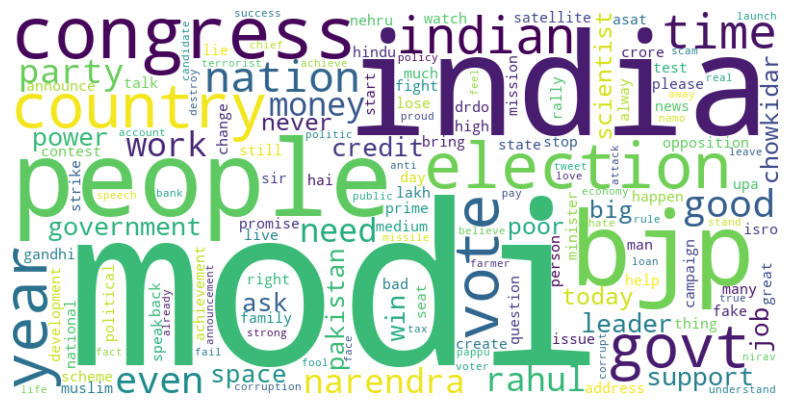

In [37]:
wc = WordCloud(width=800, height=400, background_color="white", min_font_size=10).generate(" ".join(bow.feature_names))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show

Now, looking at the least popular words.


In [38]:
bow.feature_names[freq_order[-50:]]

array(['wave india', 'wave lose', 'giri', 'girl kidnap', 'good love',
       'transportation', 'trait modi', 'transfer account',
       'goodwill message', 'good service', 'water air', 'good number',
       'goon modi', 'goswami republic', 'gesture modi', 'good stop',
       'government attack', 'government build', 'abcd', 'trivialise',
       'zafar', 'able provide', 'able speak', 'able vote', 'able win',
       'abolish article', 'trend twitter', 'travel modi', 'travel train',
       'good even', 'gng', 'goal post', 'good achievement', 'good always',
       'raid minister', 'unnoticed', 'unofficial', 'bhatt aditi',
       'bhi aur', 'bhi berozgar', 'big danger', 'rajan modi',
       'bhupesh baghel', 'bhutan', 'rakhe', 'rally only', 'bhi mumkin',
       'zara', 'yrs people', 'trolled liberal'], dtype=object)

We still see that the themes mentioned in the most frequent terms are still present in this subset. Although, more filler or non-distinct words do appear more often, like "photos", "soft" and "types".

But the present of words like "reelection" and "wars" still point to this subset still being relevant to the main theme of the dataset.


# **5. Exploratory Data Analysis**

This section discusses the exploratory data analysis conducted on the dataset after cleaning.

> Notes from Zhean: <br>
> From manual checking via OpenRefine, there are a total of 162972. `df.info()` should have the same result post-processing.
> Furthermore, there should be two columns, `clean_text` (which is a bit of a misnormer since it is still dirty) contains the Tweets (text data). The second column is the `category` which contains the sentiment of the Tweet and is a tribool (1 positive, 0 neutral or indeterminate, and -1 for negative).


Now that we have our clean, lemmatized tweets, we can now work with a new DataFrame containing only **`lemmatized`** and the **`category`** columns.


In [39]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(["clean_text", "clean_ours"], axis=1)

df_cleaned = df_cleaned[["lemmatized", "category"]]  # for column reordering

df_cleaned

,lemmatized,category
0,modi promise minimum government maximum governance expect difficult job reform state year justice state business exit psus temple,-1
1,talk all nonsense continue all drama vote modi,0
2,just vote modi welcome bjp rahul main campaigner modi modi just relax,1
3,ask supporter prefix chowkidar modi great service confusion read crustal clear crass filthy nonsensical abuse chowkidar,1
4,answer powerful leader today trump putin modi,1
...,...,...
162975,crore pay neerav modi recover congress leader hard earn money tax payer,-1
162976,dear rss terrorist payal gawar about modi kill plus muslim listen dysfunctional little pea size brain bleat commit crime criminal irrespective hindumuslim stop criminal religious twist,-1
162977,cover interaction forum leave,0
162978,big project india modi dream project happen reality,0


Because we will be splitting this dataset later, we need to know if the distribution of the categories is balanced. An imbalanced distribution may cause a bias to the majority class. Understanding the distribution will inform us whether stratified splitting is necessary so that we do not have an under or overrepresented class.

We'll be using a bar graph as that is the simplest way for us to see the differences between the categorical data.


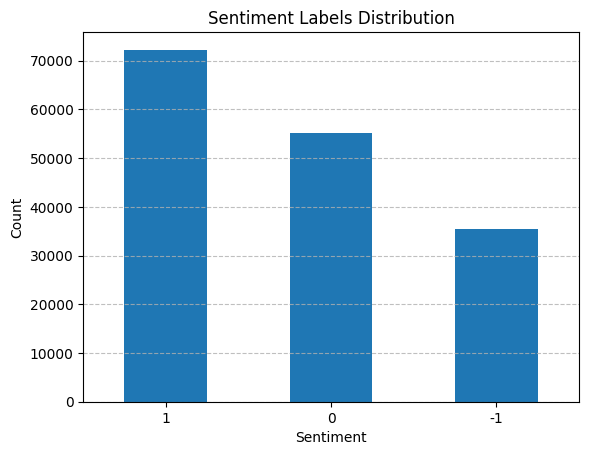

In [40]:
count = df_cleaned["category"].value_counts()

plt.title("Sentiment Labels Distribution")

count.plot(kind="bar")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)

plt.ylabel("Count")

plt.grid(axis="y", linestyle="--", alpha=0.8)  # horizontal lines

plt.show()

We can see that there is a noticeable difference between the three classes. The positive class (1) has a count of over 70,000, the neutral class (0) has around 55,000, and the negative class (-1) has around 30,000.

This imbalance indicates that we must use stratified splitting in the later section.


# **6. Dataset Splitting**

Before being able to use the dataset, we need to partition it into three sets:

1. **Training** - used to train the model to learn and change its parameters
2. **Validation** - used to evaluate the model, comparing its predictions to correct answers for hyperparameter tuning
3. **Test** - used to test the model with new, unseen data

The following section will be dedicated solely to splitting the dataset. We will split the dataset with 70% for training, 15% for validation, and 15% for testing as this is a standard partitioning.

## **Splitting the dataset into Training, Validation, and Testing sets**

We'll first split the dataset into 70% and 30% parts by using Scikit-learn's `train_test_split` function. As mentioned earlier, the distribution of categories is imbalanced, so we have to use the function's `stratify` parameter to maintain an even proportion.


In [41]:
train, temp = train_test_split(
    df_cleaned, test_size=0.3, stratify=df_cleaned["category"], random_state=5
)  # 70/30 split

print(train.shape, temp.shape)

(114059, 2) (48883, 2)


We now have our two sets for training and testing, but we're still missing one more for validation. We can split the 30% part into two halves of 15% so that we have a part for validation and the other part for testing.


In [42]:
validation, test = train_test_split(
    temp, test_size=0.5, stratify=temp["category"], random_state=5
)  # 15/15 split

print(train.shape, validation.shape, test.shape)

(114059, 2) (24441, 2) (24442, 2)


Now that we have our training, validation, and testing sets, we can use these on the models.


# **References**

Bird, S., & Loper, E. (2004, July). NLTK: The natural language toolkit. _Proceedings of the ACL Interactive Poster and Demonstration Sessions_, 214–217. https://aclanthology.org/P04-3031/

El-Demerdash, A. A., Hussein, S. E., & Zaki, J. F. W. (2021). Course evaluation based on deep learning and SSA hyperparameters optimization. _Computers, Materials & Continua, 71_(1), 941–959. https://doi.org/10.32604/cmc.2022.021839

George, M., & Murugesan, R. (2024). Improving sentiment analysis of financial news headlines using hybrid Word2Vec-TFIDF feature extraction technique. _Procedia Computer Science, 244_, 1–8.

Honnibal, M., Montani, I., Van Landeghem, S., & Boyd, A. (2020). spaCy: Industrial-strength Natural Language Processing in Python. https://doi.org/10.5281/zenodo.1212303

Hussein, S. (2021). _Twitter sentiments dataset_. Mendeley.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. _Journal of Machine Learning Research, 12_, 2825–2830.

Rani, D., Kumar, R., & Chauhan, N. (2022, October). Study and comparison of vectorization techniques used in text classification. In _2022 13th International Conference on Computing Communication and Networking Technologies (ICCCNT)_ (pp. 1–6). IEEE.

Wolfram Research. (2015). _DeleteStopwords_. https://reference.wolfram.com/language/ref/DeleteStopwords.html

# **Appendix: `clean` wrapper function definition**

Below is the definition of the `clean` wrapper function that encapsulates all internal functions used in the cleaning pipeline.


In [43]:
clean??

# **Appendix: `find_spam_and_empty` wrapper function definition**

Below is the definition of the `find_spam_and_empty` wrapper function that encapsulates all internal functions for the spam detection algorithm.


In [44]:
find_spam_and_empty??

# **Appendix: comparison of traditional vectorization techniques**

Traditional vectorization techniques include BoW and Term Frequency-Inverse Document Frequency (TF-IDF). TF-IDF weights each word based on its frequency in a document and its rarity across the corpus, reducing the impact of common words. BoW, in contrast, simply counts word occurrences without considering corpus-level frequency. In this project, BoW was chosen because stopwords were already removed during preprocessing, and the dataset is domain-specific <u>(Rani et al., 2022)</u>. In such datasets, frequent words are often meaningful domain keywords, so scaling them down (as TF-IDF would) could reduce the importance of these key terms in the feature representation.


# **Appendix: `BagOfWordsModel` class definition**

Below is the definition of the `BagOfWordsModel` class that encapsulates the desired parameters.


In [45]:
BagOfWordsModel??